**EE219 Winter 2019, Project 2**

In [1]:
# setting the random seed
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

np.random.seed(42)
random.seed(42)

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.base import BaseEstimator, TransformerMixin
import re
# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

In [ ]:
def scores(ground, clustered):
    from sklearn.metrics import homogeneity_score
    from sklearn.metrics import completeness_score
    from sklearn.metrics import v_measure_score
    from sklearn.metrics import adjusted_rand_score
    from sklearn.metrics import adjusted_mutual_info_score

    homogeneity = homogeneity_score(ground, clustered)
    completeness = completeness_score(ground, clustered)
    v_measure = v_measure_score(ground, clustered)
    adjusted_rand_index = adjusted_rand_score(ground, clustered)
    adjusted_mutual_info = adjusted_mutual_info_score(ground, clustered)

    print('kmeans clustering results with k=2')
    print('-------------------------------------------------------------------')
    print('Homegeneity: {}'.format(homogeneity))
    print('Completeness: {}'.format(completeness))
    print('V-measure: {}'.format(v_measure))
    print('Adjusted Rand Index: {}'.format(adjusted_rand_index))
    print('Adjusted Mutual Information Score: {}'.format(adjusted_mutual_info))
    print('-------------------------------------------------------------------')

In [3]:
# Set the global directory to place figs in project:
figs_dir = 'figs'

import os
if not os.path.exists(figs_dir):
    os.mkdir(figs_dir)

In [4]:
# Fetching 20NewsGroups dataset

categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics', 'comp.sys.mac.hardware', 
              'comp.os.ms-windows.misc', 'rec.autos', 'rec.motorcycles', 
              'rec.sport.baseball', 'rec.sport.hockey']

twenty_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)


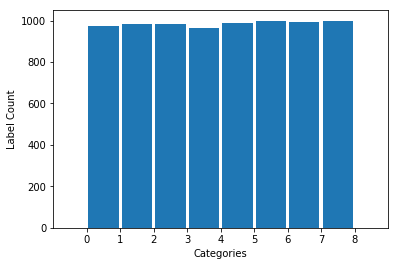

In [5]:
# Fetch all 8 news groups categories and plot a histogram of the training documents.

x = range(-1,23)
plt.hist(twenty_data.target, x, rwidth=0.9)
plt.xlabel('Categories')
plt.ylabel('Label Count')
plt.xticks(np.arange(9, step=1))
plt.xlim(left=-1, right = 9)
plt.savefig('{}/8-groups.eps'.format(figs_dir), format='eps', dpi=100)
plt.show()

In [6]:
# Change labels into binary based on two well separated classes: Class 1 (labels 0-3) and Class 2 (labels 4-7).
twenty_binary_labels = np.zeros(len(twenty_data.target))
for k in range(len(twenty_data.target)):
    if twenty_data.target[k] >= 4:
        twenty_binary_labels[k] = 1
    else:
        twenty_binary_labels[k] = 0
            
class_names = ['Class 1', 'Class 2']

**Question 1**

In [7]:
# Push documents through CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

count_vect = CountVectorizer(min_df=3, stop_words='english')

# do for the whole set
X_data = count_vect.fit_transform(twenty_data.data)

In [8]:
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_data_tfidf = tfidf_transformer.fit_transform(X_data)
print('Dimensions of the TF-IDF matrix are: {}'.format(X_data_tfidf.shape))

Dimensions of the TF-IDF matrix are: (7882, 27768)


**Question 2**

In [10]:
# Applying k-means clustering
# data is called X_data_tfidf
from sklearn.cluster import KMeans

#reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

#perfroming kmeans clsutering with k=2
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1001, n_init = 40).fit(X_data_tfidf)


**Question 2(a)**

In [11]:
# Contingency matrix
from sklearn.metrics.cluster import contingency_matrix

contingency_matrix(twenty_binary_labels, kmeans.labels_)

array([[   4, 3899],
       [1718, 2261]])

**Question 2(b)**

In [93]:
scores(twenty_binary_labels, kmeans.labels_)

NameError: name 'kmeans' is not defined

#### Question 4

In [9]:
# Perform SVD on the TF-IDF matrix
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=42)
X_data_svd = svd.fit_transform(X_data_tfidf)

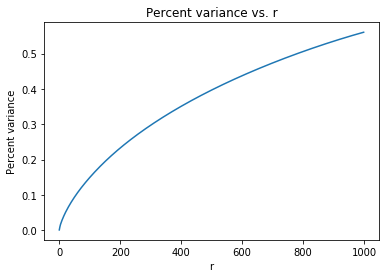

In [10]:
# Plot variance ratios

variances = svd.explained_variance_ratio_

plt.figure()
plt.plot(np.cumsum(variances))
plt.title('Percent variance vs. r')
plt.xlabel('r')
plt.ylabel('Percent variance')
plt.show()

#### Question 5

In [11]:
# Initialize r, which is basically how many components we want to use.

r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

In [12]:
# SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

In [13]:
# Import packages

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [18]:
svd_homogeneity = np.zeros(len(r))
svd_completeness = np.zeros(len(r))
svd_v = np.zeros(len(r))
svd_rand = np.zeros(len(r))
svd_mutual_info = np.zeros(len(r))

# svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40)
for i in range(len(r)):
    svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_svd_r.T[0:r[i]].T)
    svd_homogeneity[i] = homogeneity_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_completeness[i] = completeness_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_v[i] = v_measure_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_rand[i] = adjusted_rand_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_mutual_info[i] = adjusted_mutual_info_score(twenty_binary_labels, svd_kmeans.labels_)
    

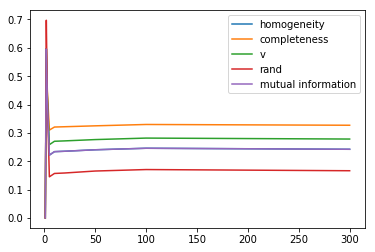

In [19]:
# Plot metrics for svd.

plt.figure()
plt.plot(r, svd_homogeneity)
plt.plot(r, svd_completeness)
plt.plot(r, svd_v)
plt.plot(r, svd_rand)
plt.plot(r, svd_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [20]:
print('Homogeneity scores: ', np.round(svd_homogeneity, 4))
print('Completeness scores: ', np.round(svd_completeness, 4))
print('V measure scores: ', np.round(svd_v, 4))
print('Adjusted rand scores: ', np.round(svd_rand, 4))
print('Adjusted mutual information scores: ', np.round(svd_mutual_info, 4))

Homogeneity scores:  [3.000e-04 5.959e-01 4.164e-01 2.217e-01 2.339e-01 2.353e-01 2.405e-01
 2.459e-01 2.423e-01]
Completeness scores:  [3.000e-04 5.970e-01 4.506e-01 3.100e-01 3.207e-01 3.218e-01 3.249e-01
 3.297e-01 3.270e-01]
V measure scores:  [3.000e-04 5.965e-01 4.329e-01 2.585e-01 2.705e-01 2.718e-01 2.765e-01
 2.817e-01 2.784e-01]
Adjusted rand scores:  [3.000e-04 6.973e-01 4.199e-01 1.452e-01 1.570e-01 1.586e-01 1.656e-01
 1.708e-01 1.666e-01]
Adjusted mutual information scores:  [2.000e-04 5.959e-01 4.164e-01 2.216e-01 2.338e-01 2.353e-01 2.405e-01
 2.458e-01 2.422e-01]


In [14]:
# Import packages

from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [22]:
# Initialize r and each an array for each metric.

r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

nmf_homogeneity = np.zeros(len(r))
nmf_completeness = np.zeros(len(r))
nmf_v = np.zeros(len(r))
nmf_rand = np.zeros(len(r))
nmf_mutual_info = np.zeros(len(r))

In [23]:
# Perform NMF for each number of components and calculate each metric

for i in range(len(r)):
    nmf = NMF(n_components=r[i])
    X_data_nmf_r = nmf.fit_transform(X_data_tfidf)
    nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_nmf_r)
    nmf_homogeneity[i] = homogeneity_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_completeness[i] = completeness_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_v[i] = v_measure_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_rand[i] = adjusted_rand_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_mutual_info[i] = adjusted_mutual_info_score(twenty_binary_labels, nmf_kmeans.labels_)

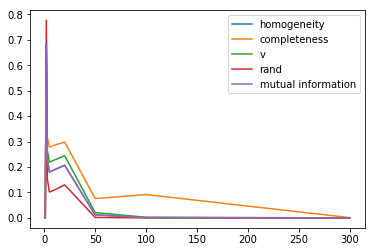

In [24]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r, nmf_homogeneity)
plt.plot(r, nmf_completeness)
plt.plot(r, nmf_v)
plt.plot(r, nmf_rand)
plt.plot(r, nmf_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [25]:
print('Homogeneity scores: ', np.round(nmf_homogeneity, 4))
print('Completeness scores: ', np.round(nmf_completeness, 4))
print('V measure scores: ', np.round(nmf_v, 4))
print('Adjusted rand scores: ', np.round(nmf_rand, 4))
print('Adjusted mutual information scores: ', np.round(nmf_mutual_info, 4))

Homogeneity scores:  [3.000e-04 6.790e-01 2.293e-01 1.806e-01 1.893e-01 2.071e-01 1.210e-02
 1.300e-03 1.000e-04]
Completeness scores:  [3.000e-04 6.801e-01 3.165e-01 2.787e-01 2.862e-01 2.982e-01 7.610e-02
 9.170e-02 1.200e-03]
V measure scores:  [3.000e-04 6.796e-01 2.660e-01 2.192e-01 2.279e-01 2.444e-01 2.080e-02
 2.500e-03 2.000e-04]
Adjusted rand scores:  [3.000e-04 7.770e-01 1.528e-01 1.020e-01 1.099e-01 1.301e-01 2.000e-03
 1.000e-04 1.000e-04]
Adjusted mutual information scores:  [2.000e-04 6.790e-01 2.293e-01 1.806e-01 1.893e-01 2.071e-01 1.200e-02
 1.200e-03 0.000e+00]


#### Question 6

<span style='color:red'>TODO</span>

Both the SVD and NMF measures have non-monotonic behaviors as r increases.

#### Question 7

Visualize the clustering results for SVD with best r and NMF with best r

In [48]:
# Visualize clustering results on 2-D plane with SVD and coloring
# Compare ground truth label and clustering label plots

# Define what the best r is for both SVD and NMF
SVD_best_r = 2
NMF_best_r = 2

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)

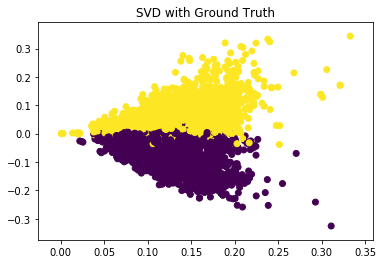

In [51]:
# SVD, ground truth

data_svd_to_plot = X_data_svd_r[:, 0:2] # Take the first two columns of the svd Data to plot

color_truth = np.zeros(len(twenty_binary_labels))

for i in range(len(twenty_binary_labels)):
    if twenty_binary_labels[i] == 0:
        color_truth[i] = 1

plt.scatter(data_svd_to_plot[:,0] ,data_svd_to_plot[:,1], c = color_truth)
plt.title('SVD with Ground Truth')
plt.show()

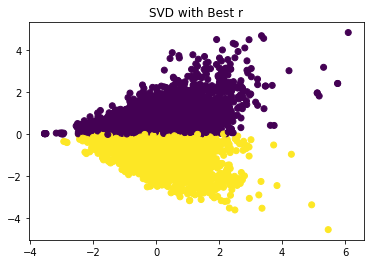

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6083906451349058
Completeness: 0.6086735382744709
V-measure: 0.608532058826994
Adjusted Rand Index: 0.7130690688676673
Adjusted Mutual Information Score: 0.6083547931827824
-------------------------------------------------------------------


In [94]:
# SVD with best r

svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_svd_r.T[0:SVD_best_r].T)

svd_to_plot = svd_kmeans.labels_

color_svd = np.zeros(len(svd_to_plot))

for i in range(len(svd_to_plot)):
    if svd_to_plot[i] == 1:
        color_svd[i] = 1

np.shape(svd_to_plot)

plt.scatter(data_svd_to_plot[:,0] ,data_svd_to_plot[:,1], c = color_svd)
plt.title('SVD with Best r')
plt.show()

scores(twenty_binary_labels, svd_to_plot)

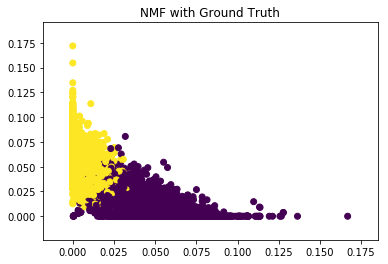

In [95]:
# NMF, ground truth

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

color_truth = np.zeros(len(twenty_binary_labels))

for i in range(len(twenty_binary_labels)):
    if twenty_binary_labels[i] == 1:
        color_truth[i] = 1      

plt.scatter(X_data_nmf_r[:,0] ,X_data_nmf_r[:,1], c = color_truth)
plt.title('NMF with Ground Truth')
plt.show()

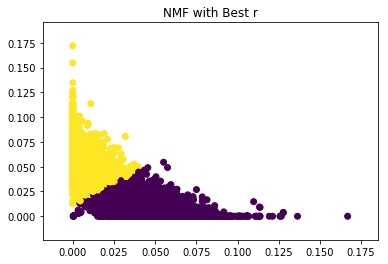

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6790483562300399
Completeness: 0.680131609210451
V-measure: 0.6795895510492934
Adjusted Rand Index: 0.7770177788377391
Adjusted Mutual Information Score: 0.6790189730005426
-------------------------------------------------------------------


In [96]:
# NMF with best r

# Reset NMF

nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    
nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_nmf_r)

nmf_to_label = nmf_kmeans.labels_

color_nmf = np.zeros(len(nmf_to_label))

for i in range(len(nmf_to_label)):
    if nmf_to_label[i] == 1:
        color_nmf[i] = 1

plt.scatter(X_data_nmf_r[:,0] ,X_data_nmf_r[:,1], c = color_nmf)
plt.title('NMF with Best r')
plt.show()

scores(twenty_binary_labels, nmf_to_label)

#### Question 8

Transforming the data

In [97]:
# Scaling features such that each feature has unit variance

def scaling (features): # Each column of the reduced dimension data has unit variance 
#     r, c = np.shape(features)
    return (features - np.mean(features,axis=0)) / np.std(features, axis=0)
    
# #     for j in range(c):
# #         var = np.var(features[:,j])
# #         for i in range(r):
# #             scaled[i,j] = features[i,j]/np.sqrt(var)        
#     return features  

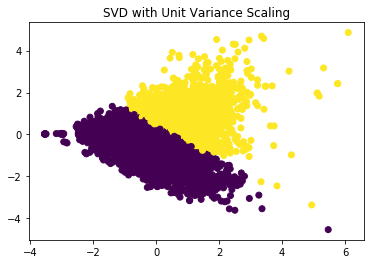

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.23570499830708622
Completeness: 0.2641571403517944
V-measure: 0.24912132167671328
Adjusted Rand Index: 0.2551379564336936
Adjusted Mutual Information Score: 0.2356350238574084
-------------------------------------------------------------------


In [99]:
# SVD with Unit Variance Transform

svd_uv_transform = scaling(X_data_svd_r)
svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(svd_uv_transform.T[0:SVD_best_r].T)

svd_uv_labels = svd_kmeans.labels_

color_svd = np.zeros(len(svd_uv_labels))

for i in range(len(svd_uv_labels)):
    if svd_uv_labels[i] == 0:
        color_svd[i] = 1

plt.scatter(svd_uv_transform[:,0] ,svd_uv_transform[:,1], c = color_svd)
plt.title('SVD with Unit Variance Scaling')
plt.show()

scores(twenty_binary_labels, svd_uv_labels)

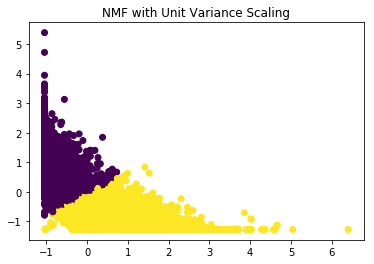

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6828038321574016
Completeness: 0.6856459752144646
V-measure: 0.6842219522524521
Adjusted Rand Index: 0.7734426774605906
Adjusted Mutual Information Score: 0.6827747927166996
-------------------------------------------------------------------


In [100]:
# NMF with Unit Variance Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_uv_transform = scaling(X_data_nmf_r)

nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_uv_transform)

nmf_uv_labels = nmf_kmeans.labels_

color_nmf = np.zeros(len(nmf_uv_labels))

for i in range(len(nmf_uv_labels)):
    if nmf_uv_labels[i] == 0:
        color_nmf[i] = 1

plt.scatter(nmf_uv_transform[:,0] ,nmf_uv_transform[:,1], c = color_nmf)
plt.title('NMF with Unit Variance Scaling')
plt.show()

scores(twenty_binary_labels, nmf_uv_labels)

In [101]:
# Logarithm transformation 

# Create def here

def logarithm_trans (features): # Each column of the reduced dimension data has unit variance 
    
    c_const = 0.01
    
    return np.sign(features) * (np.log(np.abs(features) + c_const) - np.log(c_const))

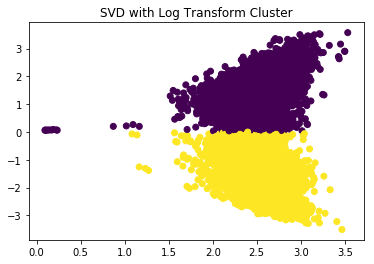

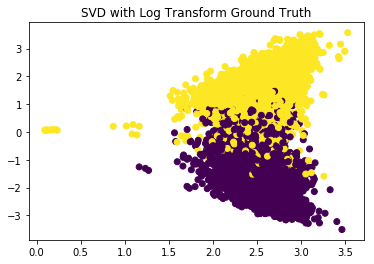

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6103417043340299
Completeness: 0.6103071485507172
V-measure: 0.6103244259532477
Adjusted Rand Index: 0.7173615345618276
Adjusted Mutual Information Score: 0.6102714740816841
-------------------------------------------------------------------


In [103]:
# SVD with Logarithm Transform

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

svd_log_transform = logarithm_trans(X_data_svd_r)
svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(svd_log_transform[:, 0:SVD_best_r])

svd_log_label = svd_kmeans.labels_

color_svd = np.zeros(len(svd_to_label))

for i in range(len(svd_log_label)):
    if svd_log_label[i] == 0:
        color_svd[i] = 1
        
color_truth = np.zeros(len(twenty_binary_labels))

for i in range(len(twenty_binary_labels)):
    if twenty_binary_labels[i] == 0:
        color_truth[i] = 1        

plt.scatter(svd_log_transform[:,0] ,svd_log_transform[:,1], c = color_svd)
plt.title('SVD with Log Transform Cluster')
plt.show()

plt.scatter(svd_log_transform[:,0] ,svd_log_transform[:,1], c = color_truth)
plt.title('SVD with Log Transform Ground Truth')
plt.show()

scores(twenty_binary_labels, svd_log_label)

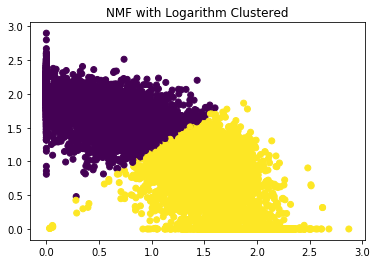

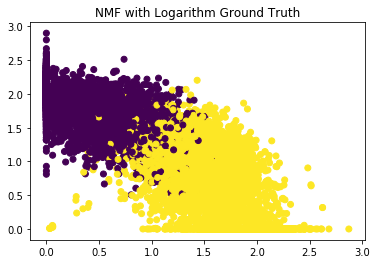

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6757033916294439
Completeness: 0.6791388923298461
V-measure: 0.6774167862456966
Adjusted Rand Index: 0.7649847921825073
Adjusted Mutual Information Score: 0.6756737021308169
-------------------------------------------------------------------


In [104]:
# NMF with Logarithm Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_log_transform = logarithm_trans(X_data_nmf_r)

nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_log_transform)

nmf_log_labels = nmf_kmeans.labels_

color_nmf = np.zeros(len(nmf_log_labels))
color_truth = np.zeros(len(twenty_binary_labels))

for i in range(len(twenty_binary_labels)):
    if twenty_binary_labels[i] == 0:
        color_truth[i] = 1

for i in range(len(nmf_log_labels)):
    if nmf_log_labels[i] == 0:
        color_nmf[i] = 1
        
# Redefine NMF for ploting      

plt.scatter(nmf_log_transform[:,0] ,nmf_log_transform[:,1], c = color_nmf)
plt.title('NMF with Logarithm Clustered')
plt.show()

plt.scatter(nmf_log_transform[:,0] ,nmf_log_transform[:,1], c = color_truth)
plt.title('NMF with Logarithm Ground Truth')
plt.show()

scores(twenty_binary_labels, nmf_log_labels

#### Question 11

##### Pull in the 20-category dataset

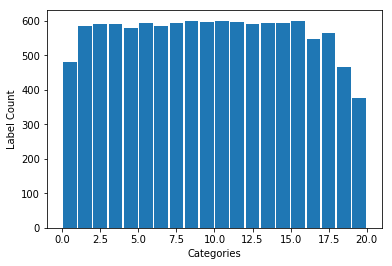

20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [43]:
# Fetch all 20 news groups categories and plot a histogram of the training documents.

twenty_data20 = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
x = range(-1,23)
plt.hist(twenty_data20.target, x, rwidth=0.9)
plt.xlabel('Categories')
plt.ylabel('Label Count')
plt.xlim(xmin=-1, xmax = 21)
plt.savefig('{}/20-groups.eps'.format(figs_dir), format='eps', dpi=100)
plt.show()

categories = twenty_data20.target_names
print(len(categories)) # there should be 20
print(categories)

##### Redo CountVect and TF-IDF calculations

In [71]:
# Push documents through CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

count_vect20 = CountVectorizer(min_df=3, stop_words='english')

# do for the whole set
X_data20 = count_vect20.fit_transform(twenty_data20.data)

In [72]:
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer20 = TfidfTransformer()

# do for training
X_data_tfidf20 = tfidf_transformer20.fit_transform(X_data20)
print('Dimensions of the TF-IDF matrix are: {}'.format(X_data_tfidf20.shape))

Dimensions of the TF-IDF matrix are: (11314, 38563)


##### Applying K-means

In [73]:
# Applying k-means clustering
# data is called X_data_tfidf
from sklearn.cluster import KMeans
import time

#reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

#perfroming kmeans clsutering with k=20
start_time = time.time()
kmeans20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init = 40, n_jobs=-1).fit(X_data_tfidf20)
print('Time taken for kmean 20-class clustering: {:.2f} minutes'.format((time.time() - start_time)/60))
      
kmeans_labels= kmeans20.labels_
category_labels = twenty_data20.target

Time taken for kmean 20-class clustering: 46.09 minutes


#### Report the 5 measures:

In [74]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

homogeneity = homogeneity_score(category_labels, kmeans_labels)
completeness = completeness_score(category_labels, kmeans_labels)
v_measure = v_measure_score(category_labels, kmeans_labels)
adjusted_rand_index = adjusted_rand_score(category_labels, kmeans_labels)
adjusted_mutual_info = adjusted_mutual_info_score(category_labels, kmeans_labels)

print('kmeans clustering results with k=20')
print('-------------------------------------------------------------------')
print('Homegeneity: {}'.format(homogeneity))
print('Completeness: {}'.format(completeness))
print('V-measure: {}'.format(v_measure))
print('Adjusted Rand Index: {}'.format(adjusted_rand_index))
print('Adjusted Mutual Information Score: {}'.format(adjusted_mutual_info))
print('-------------------------------------------------------------------')

kmeans clustering results with k=20
-------------------------------------------------------------------
Homegeneity: 0.34476681370081913
Completeness: 0.4250283412607037
V-measure: 0.3807134040907847
Adjusted Rand Index: 0.12391949549226418
Adjusted Mutual Information Score: 0.3411630906533835
-------------------------------------------------------------------


##### and the contingency matrix:

In [75]:
# Contingency matrix
from sklearn.metrics.cluster import contingency_matrix

contingency_matrix(category_labels, kmeans_labels)

array([[  0,   5, 115,   0,   0,   0,   0,   0,  55,   0,  13, 146, 110,
          1,  35,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,  85,   0,   1,   0,  61,   0,   5, 177,   1,
         11,  52,   0,   0, 189,   1,   0],
       [  0,   0,   0,   0,  95,   0,   0,   7,  35,   0,   7,  67,   0,
          1,  38,   0,   0, 311,  30,   0],
       [  0,   0,   0,   0, 222,   0,   1, 141,  74,   0,  19,  58,   0,
          5,  14,   0,   0,  48,   8,   0],
       [  0,   0,   0,   0, 331,   0,   2,  57,  38,   0,  26,  87,   0,
          8,  17,   0,   0,   2,  10,   0],
       [  0,   0,   0,   2,   7,   0,   0,   0,  79,   0,   5,  98,   0,
         16,  49,   0,   0, 272,  65,   0],
       [  6,   0,   0,   0, 326,   0,   5,  21,  68,   0,  25, 106,   0,
          3,   4,   0,   0,  13,   8,   0],
       [  0,   6,   1,   0,   3,   0,   1,   0, 236,   0,  33, 303,   0,
          1,   6,   0,   0,   3,   1,   0],
       [  0,   0,   0,   0,   3,   0,   5,   0, 292,   0,  10, 2

#### Question 12

##### Analyzing SVD:

In [76]:
# Initialize r, which is basically how many components we want to use.

r20 = [1, 2, 3, 5, 10, 20, 50, 100, 300]

In [84]:
# SVD

from sklearn.decomposition import TruncatedSVD

svd20 = TruncatedSVD(n_components=r20[-1])
X_data_svd_r20 = svd20.fit_transform(X_data_tfidf20)

In [ ]:
# Import packages

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [1]:
svd_homogeneity = np.zeros(len(r20))
svd_completeness = np.zeros(len(r20))
svd_v = np.zeros(len(r20))
svd_rand = np.zeros(len(r20))
svd_mutual_info = np.zeros(len(r20))

category_labels = twenty_data20.target

import time
start_time = time.time()

for i in range(len(r20)):
    interm_time = time.time()
    svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_svd_r20[:, 0:r20[i]])
    svd_homogeneity[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
    svd_completeness[i] = completeness_score(category_labels, svd_kmeans.labels_)
    svd_v[i] = v_measure_score(category_labels, svd_kmeans.labels_)
    svd_rand[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
    svd_mutual_info[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
    print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    
print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

NameError: name 'np' is not defined

In [ ]:
# Plot metrics for svd.

plt.figure()
plt.plot(r, svd_homogeneity)
plt.plot(r, svd_completeness)
plt.plot(r, svd_v)
plt.plot(r, svd_rand)
plt.plot(r, svd_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [ ]:
print('Homogeneity scores: ', np.round(svd_homogeneity, 4))
print('Completeness scores: ', np.round(svd_completeness, 4))
print('V measure scores: ', np.round(svd_v, 4))
print('Adjusted rand scores: ', np.round(svd_rand, 4))
print('Adjusted mutual information scores: ', np.round(svd_mutual_info, 4))

##### Analyzing NMF:

In [ ]:
# Import packages

from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [ ]:
# Initialize an array for each metric.

nmf_homogeneity = np.zeros(len(r20))
nmf_completeness = np.zeros(len(r20))
nmf_v = np.zeros(len(r20))
nmf_rand = np.zeros(len(r20))
nmf_mutual_info = np.zeros(len(r20))

In [ ]:
# Perform NMF for each number of components and calculate each metric

category_labels = twenty_data20.target

import time
start_time = time.time()

for i in range(len(r20)):
    interm_time = time.time()
    nmf = NMF(n_components=r20[i])
    X_data_nmf_r = nmf.fit_transform(X_data_tfidf20)
    nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_nmf_r)
    nmf_homogeneity[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
    nmf_completeness[i] = completeness_score(category_labels, nmf_kmeans.labels_)
    nmf_v[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
    nmf_rand[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
    nmf_mutual_info[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
    print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

In [ ]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r, nmf_homogeneity)
plt.plot(r, nmf_completeness)
plt.plot(r, nmf_v)
plt.plot(r, nmf_rand)
plt.plot(r, nmf_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [ ]:
print('Homogeneity scores: ', np.round(nmf_homogeneity, 4))
print('Completeness scores: ', np.round(nmf_completeness, 4))
print('V measure scores: ', np.round(nmf_v, 4))
print('Adjusted rand scores: ', np.round(nmf_rand, 4))
print('Adjusted mutual information scores: ', np.round(nmf_mutual_info, 4))